## Tic-Tac-Toe Agent
​
In this notebook, we build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:


*   Defining epsilon-greedy strategy
*   Tracking state-action pairs for convergence
*   Define hyperparameters for the Q-learning algorithm
*   Generating episode and applying Q-update equation
*   Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [ ]:
from TC_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
### vim TC_Env.py in non-pro colab
# !pip install kora
# from kora import console
# console.start()

In [ ]:
env = TicTacToe()

In [ ]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [ ]:
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [ ]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] # call environment as env
    return valid_Actions

In [ ]:
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

In [ ]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    if state_key not in Q_dict.keys():
        valid_act = valid_actions(state)
        for action in valid_act:
            Q_dict[state_key][action]=0


#### Epsilon-greedy strategy 

In [ ]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:  #Exploit: this gets the action corresponding to max q-value of current state
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   
    else:  #Explore: randomly choosing and action
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    
    
    return action




#### Tracking the state-action pairs for checking convergence 

In [ ]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [ ]:
# Initialise states to be tracked
def initialise_tracking_states():
    ## sample 4 
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(4,9)),('8-x-x-x-9-x-5-x-4',(2,1)),
                       ('x-3-x-x-5-x-4-x-8',(7,7)),('3-x-x-x-6-x-7-x-8',(3,5))]    
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
  
  
  
  

In [ ]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [ ]:
initialise_tracking_states()

In [ ]:
States_track

defaultdict(dict,
            {'3-x-x-x-6-x-7-x-8': {(3, 5): []},
             '8-x-x-x-9-x-5-x-4': {(2, 1): []},
             'x-3-x-x-5-x-4-x-8': {(7, 7): []},
             'x-x-x-x-x-x-x-x-x': {(4, 9): []}})

#### Define hyperparameters  

In [ ]:
EPISODES = 20000000
LR = 0.7                   # learning rate
GAMMA = 0.7                # discount factor

max_epsilon = 1.0
min_epsilon = 0.0001
decay_rate = 0.00003        # epsilon decay rate
threshold = 100000       # no of episodes after which states_tracked will be saved
v_threshold = 30000       # no of episodes after which verbose rewards and largest diff in q value
policy_threshold = 100000   # no of episodes after which Q dictionary/table will be saved
initialise_tracking_states()

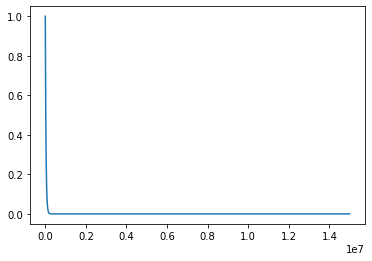

In [ ]:
## analyse how many explore/exploit
time_x = np.arange(0,EPISODES)
epsilon = []
for time_i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time_i))

plt.plot(time_x, epsilon)
plt.show()


### Q-update loop 

In [ ]:
start_time = time.time()
total_reward_convergence = []
deltas = []
env = TicTacToe() # call the environment
for episode in tqdm(range(EPISODES)):
    env.reset()
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary
    total_reward = 0 #tracking
    biggest_change = 0 #tracking
    while done != True:  
        curr_state_str = Q_state(curr_state)
        # applying epislon method, to decide action; epsilon ->  0 means action take greed actions
        curr_action = epsilon_greedy(curr_state, episode)   
        next_state, reward, done = env.step(curr_state, curr_action) # take agent action, getting reward
        next_state_key = Q_state(next_state)
        add_to_dict(next_state)
        total_reward += reward #tracking
        old_q = Q_dict[curr_state_str][curr_action] #tracking
        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_key],key=Q_dict[next_state_key].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_str][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_key][max_next])))
                                                      - Q_dict[curr_state_str][curr_action] ) 
        else:
          # if the next state is a terminal state, then the Q-values from that state are 0.
            Q_dict[curr_state_str][curr_action] += LR * ((reward - Q_dict[curr_state_str][curr_action]))
        
        biggest_change = max(biggest_change, np.abs(Q_dict[curr_state_str][curr_action] - old_q))
        # navigating to next state
        curr_state = next_state

    total_reward_convergence.append(total_reward)
    deltas.append(biggest_change)
    # states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')
    if ((episode+1)%v_threshold)==0:
        print("avg",np.mean(total_reward_convergence[:-v_threshold]),np.mean(deltas[:-v_threshold]))

    # save Policy_Q_dict
    if ((episode+1)% policy_threshold) == 0:  #every policy_thresholdth episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
save_obj(total_reward_convergence,'Rewards')   
save_obj(deltas,'Deltas')   


  0%|          | 29929/15000000 [00:27<3:17:15, 1264.87it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 30181/15000000 [00:27<3:24:13, 1221.72it/s]

avg nan nan


  0%|          | 60272/15000000 [00:49<3:27:41, 1198.85it/s]

avg -3.6123666666666665 4.093943593012954


  1%|          | 90254/15000000 [01:11<2:53:25, 1432.81it/s]

avg -3.56425 4.060679680936184


  1%|          | 120256/15000000 [01:30<2:21:24, 1753.79it/s]

avg -3.4241888888888887 4.046161444103638


  1%|          | 150244/15000000 [01:47<2:45:22, 1496.56it/s]

avg -3.221325 4.038783876930173


  1%|          | 180205/15000000 [02:05<2:28:41, 1661.05it/s]

avg -2.976053333333333 4.027284056094727


  1%|▏         | 210339/15000000 [02:23<2:14:28, 1833.03it/s]

avg -2.7615166666666666 4.011366977303346


  2%|▏         | 240193/15000000 [02:38<2:33:31, 1602.38it/s]

avg -2.4872428571428573 3.993711704877625


  2%|▏         | 270285/15000000 [02:53<2:08:11, 1914.97it/s]

avg -2.2546708333333334 3.980483660446156


  2%|▏         | 299969/15000000 [03:07<1:55:51, 2114.56it/s]

avg -2.0122444444444443 3.9607474548075943


  2%|▏         | 330324/15000000 [03:23<2:01:38, 2010.00it/s]

avg -1.70161 3.918960546478647


  2%|▏         | 360208/15000000 [03:36<2:12:34, 1840.46it/s]

avg -1.3942424242424243 3.8880362141658864


  3%|▎         | 390462/15000000 [03:50<2:07:05, 1915.95it/s]

avg -1.0256472222222222 3.832879798486863


  3%|▎         | 420299/15000000 [04:05<2:24:37, 1680.19it/s]

avg -0.832748717948718 3.808311854478164


  3%|▎         | 450331/15000000 [04:18<2:09:38, 1870.55it/s]

avg -0.6429690476190476 3.7826106582124996


  3%|▎         | 480255/15000000 [04:31<2:00:09, 2013.84it/s]

avg -0.4716 3.751895767397989


  3%|▎         | 510518/15000000 [04:47<1:55:22, 2093.19it/s]

avg -0.39225 3.7450969830185663


  4%|▎         | 540298/15000000 [04:59<1:59:41, 2013.46it/s]

avg -0.268443137254902 3.7334255573108464


  4%|▍         | 570376/15000000 [05:11<1:59:13, 2017.26it/s]

avg -0.10494074074074074 3.7072668441459973


  4%|▍         | 599903/15000000 [05:24<1:38:43, 2430.92it/s]

avg 0.027066666666666666 3.6865788115518723


  4%|▍         | 630241/15000000 [05:39<2:18:11, 1733.12it/s]

avg 0.082765 3.676144280122464


  4%|▍         | 660288/15000000 [05:53<2:07:38, 1872.27it/s]

avg 0.163684126984127 3.665515596816112


  5%|▍         | 690316/15000000 [06:06<3:29:41, 1137.33it/s]

avg 0.18904848484848485 3.669660343467433


  5%|▍         | 720455/15000000 [06:21<2:17:40, 1728.74it/s]

avg 0.26691884057971016 3.6606839221899694


  5%|▌         | 750346/15000000 [06:34<2:37:27, 1508.33it/s]

avg 0.3357736111111111 3.652726698863334


  5%|▌         | 780469/15000000 [06:47<2:21:34, 1673.93it/s]

avg 0.39892266666666665 3.642488035214751


  5%|▌         | 810262/15000000 [07:03<2:29:21, 1583.46it/s]

avg 0.43344615384615387 3.642349608846131


  6%|▌         | 840322/15000000 [07:17<2:10:41, 1805.63it/s]

avg 0.4815530864197531 3.640898479727915


  6%|▌         | 870406/15000000 [07:30<2:28:13, 1588.76it/s]

avg 0.5143809523809524 3.640981653162081


  6%|▌         | 899841/15000000 [07:43<1:44:51, 2241.06it/s]

avg 0.5489781609195402 3.635892046513819


  6%|▌         | 930412/15000000 [08:00<2:22:31, 1645.28it/s]

avg 0.5789622222222223 3.6333512585407646


  6%|▋         | 960383/15000000 [08:13<2:29:53, 1561.03it/s]

avg 0.6022612903225807 3.6334806433591487


  7%|▋         | 990261/15000000 [08:27<2:49:37, 1376.49it/s]

avg 0.6275864583333334 3.6258882667845937


  7%|▋         | 1020444/15000000 [08:43<2:16:35, 1705.84it/s]

avg 0.626740404040404 3.622684466112008


  7%|▋         | 1050359/15000000 [08:55<2:12:23, 1756.18it/s]

avg 0.6619019607843137 3.614306189654422


  7%|▋         | 1080220/15000000 [09:07<2:35:01, 1496.53it/s]

avg 0.7351371428571428 3.59902967414449


  7%|▋         | 1110286/15000000 [09:23<2:29:18, 1550.39it/s]

avg 0.80445 3.584967158030804


  8%|▊         | 1140354/15000000 [09:35<2:15:36, 1703.43it/s]

avg 0.8693918918918919 3.57254614721864


  8%|▊         | 1170503/15000000 [09:47<2:25:20, 1585.82it/s]

avg 0.9364649122807017 3.5577802575271966


  8%|▊         | 1199796/15000000 [09:59<1:27:37, 2625.04it/s]

avg 0.986148717948718 3.5469603963082634


  8%|▊         | 1230453/15000000 [10:15<2:30:58, 1520.00it/s]

avg 1.0369925 3.536484343992871


  8%|▊         | 1260547/15000000 [10:27<2:12:34, 1727.25it/s]

avg 1.086460975609756 3.5273300950945043


  9%|▊         | 1290409/15000000 [10:38<2:08:30, 1778.12it/s]

avg 1.1439079365079365 3.515024426848883


  9%|▉         | 1320360/15000000 [10:53<2:23:34, 1587.96it/s]

avg 1.2191023255813953 3.4932434402653665


  9%|▉         | 1350569/15000000 [11:04<1:51:20, 2043.07it/s]

avg 1.3060462121212122 3.4663880651075254


  9%|▉         | 1380307/15000000 [11:15<2:30:51, 1504.73it/s]

avg 1.384637037037037 3.4422812217908665


  9%|▉         | 1410452/15000000 [11:32<2:31:36, 1493.92it/s]

avg 1.4540898550724637 3.422562297900137


 10%|▉         | 1440508/15000000 [11:44<2:39:27, 1417.24it/s]

avg 1.500818439716312 3.4122517379346013


 10%|▉         | 1470410/15000000 [11:56<2:09:43, 1738.24it/s]

avg 1.5212326388888888 3.4083307221720744


 10%|▉         | 1499897/15000000 [12:06<1:14:57, 3001.83it/s]

avg 1.581495918367347 3.391077544275032


 10%|█         | 1530503/15000000 [12:24<2:34:30, 1452.90it/s]

avg 1.6441693333333334 3.3733190094755168


 10%|█         | 1560554/15000000 [12:35<2:21:59, 1577.45it/s]

avg 1.6661359477124182 3.367026292217514


 11%|█         | 1590254/15000000 [12:46<2:58:42, 1250.64it/s]

avg 1.7134641025641026 3.356155100616779


 11%|█         | 1620382/15000000 [13:03<2:24:08, 1547.05it/s]

avg 1.7556427672955974 3.346481165386919


 11%|█         | 1650565/15000000 [13:14<2:29:28, 1488.50it/s]

avg 1.7922351851851852 3.3373261095450792


 11%|█         | 1680393/15000000 [13:24<2:26:16, 1517.71it/s]

avg 1.8546242424242425 3.3171777299900183


 11%|█▏        | 1710366/15000000 [13:40<2:35:42, 1422.52it/s]

avg 1.9248363095238095 3.2935648337106618


 12%|█▏        | 1740511/15000000 [13:50<2:09:50, 1701.91it/s]

avg 1.978477192982456 3.2769068429115866


 12%|█▏        | 1770404/15000000 [13:59<2:10:29, 1689.77it/s]

avg 2.0611103448275863 3.244906074830274


 12%|█▏        | 1799901/15000000 [14:08<1:06:42, 3298.21it/s]

avg 2.150017514124294 3.2084571091901144


 12%|█▏        | 1830525/15000000 [14:22<2:08:13, 1711.83it/s]

avg 2.2389205555555556 3.170913773434291


 12%|█▏        | 1860469/15000000 [14:32<2:04:26, 1759.76it/s]

avg 2.3248147540983606 3.1346744084386255


 13%|█▎        | 1890552/15000000 [14:41<2:06:29, 1727.33it/s]

avg 2.4091118279569894 3.0984942078271533


 13%|█▎        | 1920405/15000000 [14:55<2:08:45, 1693.01it/s]

avg 2.489157671957672 3.0644215429914197


 13%|█▎        | 1950450/15000000 [15:04<2:05:15, 1736.33it/s]

avg 2.5690203125 3.0297809195608685


 13%|█▎        | 1980496/15000000 [15:13<2:11:30, 1649.95it/s]

avg 2.647031282051282 2.9957896351630655


 13%|█▎        | 2010471/15000000 [15:27<2:11:43, 1643.50it/s]

avg 2.7228085858585858 2.962610958401623


 14%|█▎        | 2040635/15000000 [15:37<2:04:14, 1738.39it/s]

avg 2.7964452736318406 2.930382484246834


 14%|█▍        | 2070395/15000000 [15:46<2:06:25, 1704.46it/s]

avg 2.8681833333333335 2.89874243813463


 14%|█▍        | 2099699/15000000 [15:54<1:02:11, 3457.05it/s]

avg 2.937848309178744 2.8680877700822007


 14%|█▍        | 2130551/15000000 [16:08<2:04:41, 1720.18it/s]

avg 3.0057938095238095 2.838034840958213


 14%|█▍        | 2160331/15000000 [16:17<2:09:08, 1657.08it/s]

avg 3.071855399061033 2.808769573506225


 15%|█▍        | 2190382/15000000 [16:27<2:07:02, 1680.61it/s]

avg 3.1360939814814817 2.7803857557066474


 15%|█▍        | 2220509/15000000 [16:40<2:13:25, 1596.35it/s]

avg 3.198615525114155 2.7526451413900546


 15%|█▌        | 2250548/15000000 [16:49<2:05:00, 1699.74it/s]

avg 3.259334684684685 2.7257497694783077


 15%|█▌        | 2280515/15000000 [16:59<2:31:11, 1402.20it/s]

avg 3.3186395555555555 2.6995078203544667


 15%|█▌        | 2310641/15000000 [17:12<2:05:49, 1680.77it/s]

avg 3.3707434210526315 2.6772514359787207


 16%|█▌        | 2340570/15000000 [17:22<2:13:26, 1581.19it/s]

avg 3.420533766233766 2.656488158849931


 16%|█▌        | 2370431/15000000 [17:31<2:11:55, 1595.59it/s]

avg 3.472463675213675 2.6344102280584805


 16%|█▌        | 2399861/15000000 [17:40<1:02:10, 3377.71it/s]

avg 3.5247628691983124 2.6115432902980746


 16%|█▌        | 2430384/15000000 [17:54<2:13:21, 1570.94it/s]

avg 3.5766304166666667 2.5887357535410374


 16%|█▋        | 2460467/15000000 [18:03<2:11:20, 1591.19it/s]

avg 3.626389711934156 2.5669435885130887


 17%|█▋        | 2490500/15000000 [18:12<2:04:26, 1675.47it/s]

avg 3.675468699186992 2.5454515672250135


 17%|█▋        | 2520622/15000000 [18:26<2:05:27, 1657.79it/s]

avg 3.7228763052208835 2.524655910465425


 17%|█▋        | 2550558/15000000 [18:35<2:10:20, 1591.99it/s]

avg 3.769725 2.503989657423441


 17%|█▋        | 2580581/15000000 [18:44<2:11:09, 1578.23it/s]

avg 3.8120796078431374 2.4856938849009462


 17%|█▋        | 2610340/15000000 [18:58<2:16:25, 1513.68it/s]

avg 3.8572062015503876 2.465837233607836


 18%|█▊        | 2640675/15000000 [19:07<2:11:13, 1569.66it/s]

avg 3.9014095785440612 2.446194833148207


 18%|█▊        | 2670411/15000000 [19:16<2:15:28, 1516.82it/s]

avg 3.944598863636364 2.426996400743244


 18%|█▊        | 2699693/15000000 [19:25<56:37, 3620.55it/s]

avg 3.9868430711610485 2.408196550619643


 18%|█▊        | 2730481/15000000 [19:39<2:12:35, 1542.23it/s]

avg 4.0282044444444445 2.3898675526546347


 18%|█▊        | 2760454/15000000 [19:48<2:16:42, 1492.21it/s]

avg 4.068672893772894 2.3718652303514167


 19%|█▊        | 2790580/15000000 [19:58<2:12:27, 1536.25it/s]

avg 4.108317391304348 2.3542384612750666


 19%|█▉        | 2820488/15000000 [20:11<2:15:16, 1500.56it/s]

avg 4.147012544802867 2.3370355343621942


 19%|█▉        | 2850644/15000000 [20:21<2:14:53, 1501.06it/s]

avg 4.1849035460992905 2.320230073552136


 19%|█▉        | 2880466/15000000 [20:30<2:14:11, 1505.29it/s]

avg 4.2220080701754386 2.303719387118052


 19%|█▉        | 2910358/15000000 [20:43<2:15:01, 1492.33it/s]

avg 4.258343055555556 2.287467801935984


 20%|█▉        | 2940487/15000000 [20:53<2:14:58, 1489.12it/s]

avg 4.293658075601375 2.2717234554558754


 20%|█▉        | 2970707/15000000 [21:02<2:12:44, 1510.35it/s]

avg 4.3284901360544215 2.25623067164071


 20%|█▉        | 2999955/15000000 [21:11<58:11, 3437.39it/s]

avg 4.362693265993266 2.240964378951853


 20%|██        | 3030381/15000000 [21:25<2:13:54, 1489.72it/s]

avg 4.396139666666667 2.2260221900799464


 20%|██        | 3060342/15000000 [21:34<2:18:15, 1439.25it/s]

avg 4.428683828382838 2.2115852437546817


 21%|██        | 3090603/15000000 [21:44<2:13:28, 1487.12it/s]

avg 4.460914379084968 2.1972215694905737


 21%|██        | 3120436/15000000 [21:57<2:14:59, 1466.67it/s]

avg 4.492513268608414 2.183148769010629


 21%|██        | 3150479/15000000 [22:07<2:16:45, 1444.11it/s]

avg 4.523512179487179 2.169343566421024


 21%|██        | 3180447/15000000 [22:16<2:16:12, 1446.20it/s]

avg 4.553613968253968 2.1560299619084677


 21%|██▏       | 3210580/15000000 [22:30<2:17:56, 1424.47it/s]

avg 4.583380503144654 2.1428118776103964


 22%|██▏       | 3240383/15000000 [22:39<2:18:11, 1418.29it/s]

avg 4.612399376947041 2.1300069327711166


 22%|██▏       | 3270468/15000000 [22:48<2:15:31, 1442.56it/s]

avg 4.64097962962963 2.117341895344346


 22%|██▏       | 3299954/15000000 [22:57<56:46, 3434.46it/s]

avg 4.668886544342508 2.1050527220260578


 22%|██▏       | 3330539/15000000 [23:11<2:21:45, 1372.06it/s]

avg 4.696517575757576 2.0927791460917784


 22%|██▏       | 3360543/15000000 [23:21<2:15:40, 1429.79it/s]

avg 4.723682282282282 2.0806638475151473


 23%|██▎       | 3390567/15000000 [23:30<2:19:04, 1391.34it/s]

avg 4.750407738095238 2.0687618235446554


 23%|██▎       | 3420479/15000000 [23:44<2:17:15, 1406.12it/s]

avg 4.776691150442478 2.0569930612472125


 23%|██▎       | 3450332/15000000 [23:53<2:53:12, 1111.34it/s]

avg 4.802473099415205 2.045524251623131


 23%|██▎       | 3480657/15000000 [24:03<2:21:51, 1353.41it/s]

avg 4.827858260869565 2.0341740072244603


 23%|██▎       | 3510657/15000000 [24:16<2:19:01, 1377.30it/s]

avg 4.8528474137931035 2.0229862709532576


 24%|██▎       | 3540347/15000000 [24:26<2:24:59, 1317.25it/s]

avg 4.877382051282051 2.012035091819603


 24%|██▍       | 3570710/15000000 [24:35<2:15:36, 1404.74it/s]

avg 4.901429943502825 2.0012900498369097


 24%|██▍       | 3599715/15000000 [24:44<55:02, 3452.29it/s]

avg 4.9250428571428575 1.9907374841046872


 24%|██▍       | 3630559/15000000 [24:58<2:25:15, 1304.49it/s]

avg 4.9480225 1.98063427541052


 24%|██▍       | 3660659/15000000 [25:08<2:21:55, 1331.58it/s]

avg 4.97059173553719 1.9706918992894122


 25%|██▍       | 3690363/15000000 [25:17<2:20:21, 1342.98it/s]

avg 4.993108196721312 1.9606836963001597


 25%|██▍       | 3720494/15000000 [25:31<2:22:43, 1317.22it/s]

avg 5.015334688346884 1.9507075427121534


 25%|██▌       | 3750447/15000000 [25:41<2:23:43, 1304.57it/s]

avg 5.037186021505376 1.9409529074767813


 25%|██▌       | 3780667/15000000 [25:50<1:59:06, 1569.97it/s]

avg 5.058723733333333 1.9312389952421485


 25%|██▌       | 3810465/15000000 [26:04<2:25:20, 1283.11it/s]

avg 5.079898677248678 1.9217704336758343


 26%|██▌       | 3840605/15000000 [26:14<2:21:11, 1317.32it/s]

avg 5.100749868766404 1.9124435419816554


 26%|██▌       | 3870656/15000000 [26:23<2:19:07, 1333.28it/s]

avg 5.121154166666667 1.9033712087141663


 26%|██▌       | 3899729/15000000 [26:32<55:36, 3326.79it/s]

avg 5.141273901808786 1.894383594631899


 26%|██▌       | 3930683/15000000 [26:46<2:22:43, 1292.59it/s]

avg 5.161045641025641 1.8855585252302123


 26%|██▋       | 3960396/15000000 [26:56<2:21:06, 1303.88it/s]

avg 5.180194147582697 1.8771159356061347


 27%|██▋       | 3990659/15000000 [27:05<2:20:32, 1305.61it/s]

avg 5.199373232323232 1.8686096723566237


 27%|██▋       | 4020513/15000000 [27:19<2:29:06, 1227.19it/s]

avg 5.218341604010025 1.8601860828562957


 27%|██▋       | 4050494/15000000 [27:29<2:24:40, 1261.43it/s]

avg 5.237079104477612 1.8517814665160808


 27%|██▋       | 4080527/15000000 [27:38<2:24:05, 1263.02it/s]

avg 5.255457777777778 1.843570792681915


 27%|██▋       | 4110687/15000000 [27:52<2:27:57, 1226.60it/s]

avg 5.273640931372549 1.8353893832762973


 28%|██▊       | 4140543/15000000 [28:02<2:30:27, 1202.98it/s]

avg 5.29148905109489 1.8274611990060559


 28%|██▊       | 4170417/15000000 [28:11<2:23:35, 1257.02it/s]

avg 5.309122222222222 1.819553610728413


 28%|██▊       | 4199749/15000000 [28:20<51:44, 3479.09it/s]

avg 5.326481534772182 1.8118060504939406


 28%|██▊       | 4230574/15000000 [28:35<2:22:33, 1259.01it/s]

avg 5.343614047619048 1.804114638276979


 28%|██▊       | 4260442/15000000 [28:45<2:28:44, 1203.32it/s]

avg 5.360483924349881 1.7965943706712804


 29%|██▊       | 4290459/15000000 [28:54<2:23:07, 1247.09it/s]

avg 5.377168075117371 1.7891354105206267


 29%|██▉       | 4320361/15000000 [29:08<2:27:01, 1210.64it/s]

avg 5.3935589743589745 1.7818011543230132


 29%|██▉       | 4350621/15000000 [29:18<2:29:06, 1190.37it/s]

avg 5.409729166666667 1.7745582143820526


 29%|██▉       | 4380627/15000000 [29:27<2:28:28, 1192.00it/s]

avg 5.425704367816092 1.7674186953076576


 29%|██▉       | 4410527/15000000 [29:41<2:27:08, 1199.46it/s]

avg 5.440572374429224 1.761031430513845


 30%|██▉       | 4440636/15000000 [29:51<2:29:52, 1174.27it/s]

avg 5.4560571428571425 1.7541301648925864


 30%|██▉       | 4470554/15000000 [30:01<2:28:33, 1181.32it/s]

avg 5.471384009009009 1.7473359521885752


 30%|██▉       | 4499954/15000000 [30:09<52:13, 3350.59it/s]

avg 5.486523042505593 1.740491714413266


 30%|███       | 4530676/15000000 [30:24<2:26:17, 1192.78it/s]

avg 5.501418444444444 1.7338810149668824


 30%|███       | 4560436/15000000 [30:34<2:28:30, 1171.65it/s]

avg 5.516140838852097 1.7273208286985018


 31%|███       | 4590494/15000000 [30:44<2:27:46, 1174.08it/s]

avg 5.530656798245614 1.7208049304172288


 31%|███       | 4620629/15000000 [30:58<2:26:41, 1179.24it/s]

avg 5.545015032679738 1.7143764616130408


 31%|███       | 4650690/15000000 [31:07<2:23:59, 1197.92it/s]

avg 5.559116666666666 1.708104601895163


 31%|███       | 4680461/15000000 [31:17<2:25:02, 1185.85it/s]

avg 5.573123870967742 1.7017527828686818


 31%|███▏      | 4710664/15000000 [31:31<2:25:32, 1178.21it/s]

avg 5.586852991452991 1.695622901644072


 32%|███▏      | 4740361/15000000 [31:40<2:28:20, 1152.65it/s]

avg 5.600499787685775 1.6894988722999984


 32%|███▏      | 4770468/15000000 [31:50<2:27:54, 1152.74it/s]

avg 5.613952320675105 1.6834706012902327


 32%|███▏      | 4799964/15000000 [31:59<49:35, 3428.41it/s]

avg 5.6272507337526205 1.6774836530597528


 32%|███▏      | 4830673/15000000 [32:14<2:28:01, 1144.95it/s]

avg 5.640375 1.6716120830953594


 32%|███▏      | 4860468/15000000 [32:24<2:29:35, 1129.65it/s]

avg 5.6532898550724635 1.6658790915985024


 33%|███▎      | 4890573/15000000 [32:34<2:35:16, 1085.09it/s]

avg 5.66602695473251 1.6602335950839775


 33%|███▎      | 4920596/15000000 [32:48<2:28:04, 1134.46it/s]

avg 5.678644785276074 1.6546029888687548


 33%|███▎      | 4950497/15000000 [32:58<2:36:13, 1072.08it/s]

avg 5.691029268292683 1.6490622028125832


 33%|███▎      | 4980365/15000000 [33:07<2:32:14, 1096.87it/s]

avg 5.703361414141414 1.6435328217343272


 33%|███▎      | 5010426/15000000 [33:22<2:31:02, 1102.33it/s]

avg 5.715524497991968 1.638062373052836


 34%|███▎      | 5040481/15000000 [33:32<2:32:36, 1087.75it/s]

avg 5.727555888223553 1.6326858604553474


 34%|███▍      | 5070586/15000000 [33:41<2:33:32, 1077.81it/s]

avg 5.739457936507937 1.6272919873095326


 34%|███▍      | 5099821/15000000 [33:50<46:54, 3517.62it/s]

avg 5.751188165680474 1.6220039523864642


 34%|███▍      | 5130530/15000000 [34:05<2:27:28, 1115.33it/s]

avg 5.762773725490196 1.6168404518191133


 34%|███▍      | 5160519/15000000 [34:15<2:32:51, 1072.82it/s]

avg 5.774228849902534 1.611716918541395


 35%|███▍      | 5190718/15000000 [34:25<1:59:29, 1368.25it/s]

avg 5.78556007751938 1.6066631590443514


 35%|███▍      | 5220514/15000000 [34:40<2:29:46, 1088.23it/s]

avg 5.796798073217726 1.601636895451949


 35%|███▌      | 5250456/15000000 [34:50<2:30:07, 1082.41it/s]

avg 5.807826053639847 1.596697019573811


 35%|███▌      | 5280391/15000000 [35:00<2:34:01, 1051.68it/s]

avg 5.818770285714286 1.5918100629748766


 35%|███▌      | 5310350/15000000 [35:14<2:31:07, 1068.57it/s]

avg 5.8295660984848485 1.5870084379558729


 36%|███▌      | 5340436/15000000 [35:24<2:30:28, 1069.86it/s]

avg 5.840296610169491 1.5821993474223692


 36%|███▌      | 5370650/15000000 [35:34<2:39:27, 1006.49it/s]

avg 5.850869850187266 1.5774728010137111


 36%|███▌      | 5399742/15000000 [35:43<46:46, 3420.84it/s]

avg 5.8613104283054005 1.5728247753098694


 36%|███▌      | 5430547/15000000 [35:59<2:35:56, 1022.71it/s]

avg 5.871646296296296 1.56819126695633


 36%|███▋      | 5460625/15000000 [36:09<2:29:42, 1061.98it/s]

avg 5.881891344383057 1.5636315328667922


 37%|███▋      | 5490424/15000000 [36:19<2:30:13, 1055.01it/s]

avg 5.892033333333333 1.5590574994492787


 37%|███▋      | 5520365/15000000 [36:33<2:38:18, 998.01it/s]

avg 5.902070309653916 1.55458866929549


 37%|███▋      | 5550343/15000000 [36:43<2:33:31, 1025.80it/s]

avg 5.91199420289855 1.5501418787422478


 37%|███▋      | 5580660/15000000 [36:53<2:35:16, 1011.01it/s]

avg 5.92179945945946 1.5457406249660115


 37%|███▋      | 5610602/15000000 [37:08<2:34:13, 1014.72it/s]

avg 5.931501971326165 1.5413545894077851


 38%|███▊      | 5640592/15000000 [37:18<2:37:17, 991.74it/s]

avg 5.941073975044564 1.5370937980079917


 38%|███▊      | 5670435/15000000 [37:28<2:37:59, 984.22it/s]

avg 5.950562588652482 1.5328430508816413


 38%|███▊      | 5699731/15000000 [37:37<45:13, 3427.29it/s]

avg 5.959959611992946 1.528645550566464


 38%|███▊      | 5730483/15000000 [37:53<2:37:32, 980.61it/s]

avg 5.969246315789474 1.5245246094718778


 38%|███▊      | 5760584/15000000 [38:03<2:32:39, 1008.73it/s]

avg 5.978447643979058 1.520395651050202


 39%|███▊      | 5790540/15000000 [38:13<2:28:03, 1036.67it/s]

avg 5.987520486111111 1.5164011520641716


 39%|███▉      | 5820603/15000000 [38:27<2:38:39, 964.27it/s]

avg 5.9962402417962 1.512497775888369


 39%|███▉      | 5850349/15000000 [38:37<2:35:29, 980.72it/s]

avg 6.005170274914089 1.5085156268562696


 39%|███▉      | 5880489/15000000 [38:47<2:36:45, 969.54it/s]

avg 6.014011282051282 1.5045754830529645


 39%|███▉      | 5910652/15000000 [39:02<2:33:23, 987.64it/s]

avg 6.0227423469387755 1.5006738767690389


 40%|███▉      | 5940562/15000000 [39:12<2:30:04, 1006.14it/s]

avg 6.031374957698816 1.496837600724799


 40%|███▉      | 5970443/15000000 [39:22<2:43:14, 921.89it/s]

avg 6.039957407407408 1.492970956165707


 40%|███▉      | 5999722/15000000 [39:31<44:36, 3362.61it/s]

avg 6.048409547738694 1.489219428086137


 40%|████      | 6030426/15000000 [39:47<2:35:57, 958.51it/s]

avg 6.056792833333334 1.4854789417100478


 40%|████      | 6060382/15000000 [39:57<2:37:51, 943.88it/s]

avg 6.065113266998342 1.4817403547837424


 41%|████      | 6090440/15000000 [40:08<2:41:46, 917.86it/s]

avg 6.073282178217822 1.4780681451725843


 41%|████      | 6120585/15000000 [40:23<2:30:11, 985.31it/s]

avg 6.08144236453202 1.4744437585220067


 41%|████      | 6150483/15000000 [40:33<2:40:55, 916.48it/s]

avg 6.089507516339869 1.4707887060630516


 41%|████      | 6180607/15000000 [40:43<2:37:34, 932.87it/s]

avg 6.097490569105691 1.4672175194962764


 41%|████▏     | 6210450/15000000 [40:58<2:35:33, 941.68it/s]

avg 6.105385275080907 1.4636370768066504


 42%|████▏     | 6240582/15000000 [41:08<2:35:32, 938.58it/s]

avg 6.113217552334944 1.4601413566784802


 42%|████▏     | 6270291/15000000 [41:18<2:38:49, 916.10it/s]

avg 6.120965384615385 1.456655151768161


 42%|████▏     | 6299833/15000000 [41:27<41:41, 3478.17it/s]

avg 6.1286271132376395 1.453226150765508


 42%|████▏     | 6330593/15000000 [41:43<2:46:14, 869.14it/s]

avg 6.136185396825397 1.4498967801162825


 42%|████▏     | 6360483/15000000 [41:53<2:35:36, 925.36it/s]

avg 6.143732227488152 1.4465129146525324


 43%|████▎     | 6390529/15000000 [42:04<2:40:34, 893.65it/s]

avg 6.1512031446540885 1.443130237181536


 43%|████▎     | 6420578/15000000 [42:18<2:30:03, 952.88it/s]

avg 6.158574491392801 1.4398607094068971


 43%|████▎     | 6450350/15000000 [42:28<2:34:10, 924.29it/s]

avg 6.165890031152648 1.4366099524706335


 43%|████▎     | 6480395/15000000 [42:39<2:32:29, 931.17it/s]

avg 6.17250511627907 1.433783779410953


 43%|████▎     | 6510356/15000000 [42:53<2:38:26, 893.06it/s]

avg 6.179664197530864 1.4305986715123293


 44%|████▎     | 6540576/15000000 [43:04<2:43:28, 862.42it/s]

avg 6.1868141321044545 1.427370938295783


 44%|████▍     | 6570436/15000000 [43:14<2:31:13, 929.02it/s]

avg 6.193878899082569 1.4242081596340728


 44%|████▍     | 6599690/15000000 [43:23<41:27, 3376.59it/s]

avg 6.200876103500761 1.4211101863474516


 44%|████▍     | 6630603/15000000 [43:40<2:38:56, 877.59it/s]

avg 6.207786969696969 1.4180152656880245


 44%|████▍     | 6660408/15000000 [43:50<2:31:04, 920.03it/s]

avg 6.214660935143288 1.4149043311084584


 45%|████▍     | 6690650/15000000 [44:00<2:32:10, 910.10it/s]

avg 6.221455255255255 1.4118599235781324


 45%|████▍     | 6720383/15000000 [44:14<2:30:52, 914.67it/s]

avg 6.228200448430493 1.4088068139749683


 45%|████▌     | 6750618/15000000 [44:25<2:36:16, 879.83it/s]

avg 6.234900744047619 1.4057996357420774


 45%|████▌     | 6780596/15000000 [44:35<2:29:31, 916.21it/s]

avg 6.241512296296296 1.4028731047150824


 45%|████▌     | 6810484/15000000 [44:50<2:27:21, 926.21it/s]

avg 6.248096607669616 1.3999135288386577


 46%|████▌     | 6840479/15000000 [45:00<2:34:20, 881.11it/s]

avg 6.254632305433186 1.396967096992957


 46%|████▌     | 6870657/15000000 [45:10<2:33:19, 883.66it/s]

avg 6.261106578947368 1.3940401360415124


 46%|████▌     | 6899820/15000000 [45:19<39:12, 3443.32it/s]

avg 6.267505822416303 1.3911876895947488


 46%|████▌     | 6930458/15000000 [45:35<2:32:32, 881.68it/s]

avg 6.2738523188405795 1.3883447853604567


 46%|████▋     | 6960680/15000000 [45:45<2:28:37, 901.54it/s]

avg 6.280119336219336 1.3855883207336206


 47%|████▋     | 6990577/15000000 [45:56<2:29:24, 893.49it/s]

avg 6.286370114942529 1.3827753832595817


 47%|████▋     | 7020552/15000000 [46:10<2:32:31, 871.91it/s]

avg 6.292546494992847 1.3800137745803827


 47%|████▋     | 7050458/15000000 [46:21<2:34:26, 857.88it/s]

avg 6.298670085470086 1.3772582094564905


 47%|████▋     | 7080525/15000000 [46:31<2:30:14, 878.56it/s]

avg 6.304753617021277 1.3745365074149771


 47%|████▋     | 7110372/15000000 [46:46<2:28:17, 886.76it/s]

avg 6.31076906779661 1.371850706457593


 48%|████▊     | 7140356/15000000 [46:56<2:28:29, 882.19it/s]

avg 6.316728270042194 1.3691841573853858


 48%|████▊     | 7170323/15000000 [47:06<2:30:15, 868.46it/s]

avg 6.3226539215686275 1.3665306825146242


 48%|████▊     | 7199805/15000000 [47:15<39:09, 3320.60it/s]

avg 6.328516317991632 1.3639272147980157


 48%|████▊     | 7230490/15000000 [47:32<2:37:37, 821.49it/s]

avg 6.334378888888889 1.3612224205277577


 48%|████▊     | 7260661/15000000 [47:43<2:39:52, 806.85it/s]

avg 6.3401648686030425 1.358610884075106


 49%|████▊     | 7290542/15000000 [47:53<2:37:30, 815.81it/s]

avg 6.345878650137741 1.3560478687420108


 49%|████▉     | 7320476/15000000 [48:08<2:30:30, 850.39it/s]

avg 6.351553086419753 1.3535152666943142


 49%|████▉     | 7350425/15000000 [48:18<2:28:23, 859.18it/s]

avg 6.357191530054645 1.35100577214478


 49%|████▉     | 7380704/15000000 [48:29<1:52:55, 1124.53it/s]

avg 6.362805442176871 1.3484607109955118


 49%|████▉     | 7410420/15000000 [48:43<2:27:52, 855.39it/s]

avg 6.368347425474255 1.345984191857955


 50%|████▉     | 7440356/15000000 [48:54<2:30:25, 837.59it/s]

avg 6.373839946018894 1.3435146771812252


 50%|████▉     | 7470376/15000000 [49:04<2:26:14, 858.13it/s]

avg 6.3792912634408605 1.3410804455560061


 50%|████▉     | 7499849/15000000 [49:13<37:38, 3320.70it/s]

avg 6.3846784471218205 1.3387082168526956


 50%|█████     | 7530621/15000000 [49:29<2:27:10, 845.84it/s]

avg 6.3900264 1.3363316527898066


 50%|█████     | 7560407/15000000 [49:40<2:28:50, 833.08it/s]

avg 6.3953598937583 1.3339191160021733


 51%|█████     | 7590455/15000000 [49:50<2:33:04, 806.77it/s]

avg 6.40061455026455 1.3315866877137454


 51%|█████     | 7620514/15000000 [50:05<2:24:15, 852.56it/s]

avg 6.405871541501976 1.3292139212140959


 51%|█████     | 7650476/15000000 [50:16<2:26:06, 838.34it/s]

avg 6.411054593175853 1.3269158955792177


 51%|█████     | 7680412/15000000 [50:26<2:25:26, 838.75it/s]

avg 6.416207843137255 1.3245970376477572


 51%|█████▏    | 7710486/15000000 [50:41<2:23:36, 846.02it/s]

avg 6.421326171875 1.3222779346289972


 52%|█████▏    | 7740405/15000000 [50:51<2:24:47, 835.64it/s]

avg 6.426399351491569 1.320008972106396


 52%|█████▏    | 7770546/15000000 [51:02<2:28:45, 809.96it/s]

avg 6.4314364341085275 1.3177521678413928


 52%|█████▏    | 7799695/15000000 [51:11<35:33, 3375.51it/s]

avg 6.436426640926641 1.3155167809718102


 52%|█████▏    | 7830496/15000000 [51:27<2:27:30, 810.06it/s]

avg 6.441363076923077 1.3133332457884446


 52%|█████▏    | 7860573/15000000 [51:37<2:26:46, 810.66it/s]

avg 6.4462936143039595 1.3110962019171086


 53%|█████▎    | 7890402/15000000 [51:48<2:29:32, 792.42it/s]

avg 6.451183078880407 1.3088872174931339


 53%|█████▎    | 7920375/15000000 [52:03<2:24:54, 814.24it/s]

avg 6.456035487959443 1.3067231742781316


 53%|█████▎    | 7950491/15000000 [52:13<2:20:26, 836.54it/s]

avg 6.4608431818181815 1.3045758193823538


 53%|█████▎    | 7980614/15000000 [52:24<2:26:52, 796.52it/s]

avg 6.465592955974842 1.302462331946695


 53%|█████▎    | 8010601/15000000 [52:39<2:28:26, 784.74it/s]

avg 6.470328320802005 1.3003492353228019


 54%|█████▎    | 8040537/15000000 [52:49<2:25:40, 796.24it/s]

avg 6.4750372034956305 1.2982546764788017


 54%|█████▍    | 8070531/15000000 [53:00<2:22:10, 812.33it/s]

avg 6.479698756218905 1.2961861740054006


 54%|█████▍    | 8099761/15000000 [53:08<34:52, 3297.74it/s]

avg 6.484340396530359 1.2941099874634419


 54%|█████▍    | 8130409/15000000 [53:25<2:21:38, 808.34it/s]

avg 6.488936049382716 1.2920536734268124


 54%|█████▍    | 8160528/15000000 [53:35<2:27:27, 773.05it/s]

avg 6.493510947109471 1.2899871806967167


 55%|█████▍    | 8190559/15000000 [53:46<2:23:34, 790.44it/s]

avg 6.498036887254902 1.2879718203920847


 55%|█████▍    | 8220412/15000000 [54:01<2:24:22, 782.64it/s]

avg 6.502546642246642 1.2859370805100105


 55%|█████▌    | 8250655/15000000 [54:12<2:20:43, 799.31it/s]

avg 6.5070171532846715 1.2839383460860316


 55%|█████▌    | 8280333/15000000 [54:22<2:26:00, 767.08it/s]

avg 6.511435151515151 1.2819544270489054


 55%|█████▌    | 8310407/15000000 [54:37<2:24:20, 772.42it/s]

avg 6.515834782608696 1.2800039198654638


 56%|█████▌    | 8340515/15000000 [54:48<2:21:47, 782.76it/s]

avg 6.5201826714801445 1.2780961833515943


 56%|█████▌    | 8370487/15000000 [54:59<2:20:52, 784.29it/s]

avg 6.524525779376499 1.2761380252646057


 56%|█████▌    | 8399864/15000000 [55:08<35:29, 3100.04it/s]

avg 6.528839187574672 1.2742059717816632


 56%|█████▌    | 8430676/15000000 [55:25<2:21:29, 773.82it/s]

avg 6.533118928571429 1.2722821152676587


 56%|█████▋    | 8460613/15000000 [55:35<2:20:59, 773.03it/s]

avg 6.537361209964413 1.270391027795798


 57%|█████▋    | 8490453/15000000 [55:46<2:23:06, 758.07it/s]

avg 6.541558156028369 1.2685385610407875


 57%|█████▋    | 8520354/15000000 [56:01<2:21:51, 761.28it/s]

avg 6.545751590106007 1.2666497801267866


 57%|█████▋    | 8550466/15000000 [56:12<2:24:52, 741.95it/s]

avg 6.549922417840375 1.264767040354589


 57%|█████▋    | 8580579/15000000 [56:23<2:26:36, 729.77it/s]

avg 6.554050175438596 1.262933379427108


 57%|█████▋    | 8610470/15000000 [56:39<2:27:07, 723.84it/s]

avg 6.558153613053613 1.2610885350832906


 58%|█████▊    | 8640500/15000000 [56:50<2:21:58, 746.53it/s]

avg 6.562210569105691 1.2592746422848888


 58%|█████▊    | 8670602/15000000 [57:01<2:21:04, 747.78it/s]

avg 6.566241782407407 1.2574695716469202


 58%|█████▊    | 8699888/15000000 [57:09<31:57, 3285.10it/s]

avg 6.570261707035756 1.2556350885204255


 58%|█████▊    | 8730566/15000000 [57:26<2:22:43, 732.07it/s]

avg 6.5742436781609195 1.2538679177337801


 58%|█████▊    | 8760585/15000000 [57:37<2:22:27, 729.96it/s]

avg 6.578200458190149 1.2520977297120965


 59%|█████▊    | 8790565/15000000 [57:48<2:19:51, 739.96it/s]

avg 6.582129337899543 1.2503663383185817


 59%|█████▉    | 8820372/15000000 [58:03<2:25:21, 708.57it/s]

avg 6.586035836177475 1.2486084052649145


 59%|█████▉    | 8850509/15000000 [58:14<2:22:59, 716.78it/s]

avg 6.589926870748299 1.2468517289281675


 59%|█████▉    | 8880565/15000000 [58:25<2:14:31, 758.19it/s]

avg 6.5937781920903955 1.2451318934035105


 59%|█████▉    | 8910436/15000000 [58:40<2:22:37, 711.62it/s]

avg 6.597606981981982 1.2434347274693565


 60%|█████▉    | 8940530/15000000 [58:51<2:12:55, 759.73it/s]

avg 6.601418967452301 1.241716656041499


 60%|█████▉    | 8970518/15000000 [59:02<2:17:25, 731.23it/s]

avg 6.605209172259507 1.2399971642478405


 60%|█████▉    | 8999983/15000000 [59:11<31:15, 3198.40it/s]

avg 6.608968115942029 1.2382937729946728


 60%|██████    | 9030381/15000000 [59:28<2:21:48, 701.62it/s]

avg 6.612689 1.2366332476053372


 60%|██████    | 9060638/15000000 [59:39<2:21:07, 701.42it/s]

avg 6.61638261351052 1.235002781326158


 61%|██████    | 9090421/15000000 [59:50<2:19:22, 706.72it/s]

avg 6.620047461368653 1.233374811137323


 61%|██████    | 9120400/15000000 [1:00:07<2:30:03, 653.06it/s]

avg 6.623703850385039 1.2317256261779614


 61%|██████    | 9150521/15000000 [1:00:18<2:16:24, 714.73it/s]

avg 6.627320942982456 1.2301310445522815


 61%|██████    | 9180627/15000000 [1:00:29<2:11:43, 736.29it/s]

avg 6.630924371584699 1.2285140002072525


 61%|██████▏   | 9210640/15000000 [1:00:44<2:11:50, 731.83it/s]

avg 6.634487363834423 1.226926433472253


 62%|██████▏   | 9240401/15000000 [1:00:55<2:18:28, 693.26it/s]

avg 6.638040716612378 1.2253313966765538


 62%|██████▏   | 9270631/15000000 [1:01:06<2:16:47, 698.07it/s]

avg 6.641571103896104 1.2237424500766418


 62%|██████▏   | 9299941/15000000 [1:01:15<28:12, 3368.18it/s]

avg 6.6450807982740026 1.2221694001427632


 62%|██████▏   | 9330385/15000000 [1:01:32<2:12:11, 714.83it/s]

avg 6.648572688172043 1.2206164655367762


 62%|██████▏   | 9360584/15000000 [1:01:44<2:14:26, 699.09it/s]

avg 6.652049624866024 1.2190504894634628


 63%|██████▎   | 9390511/15000000 [1:01:55<2:11:11, 712.67it/s]

avg 6.655484829059829 1.2175280646669215


 63%|██████▎   | 9420538/15000000 [1:02:10<2:11:57, 704.67it/s]

avg 6.658903088391907 1.2160139593124766


 63%|██████▎   | 9450470/15000000 [1:02:21<2:08:31, 719.61it/s]

avg 6.662326645435244 1.2144417682869246


 63%|██████▎   | 9480432/15000000 [1:02:32<2:14:12, 685.45it/s]

avg 6.665713227513227 1.212903216196135


 63%|██████▎   | 9510477/15000000 [1:02:47<2:11:53, 693.72it/s]

avg 6.66906529535865 1.2114137073045066


 64%|██████▎   | 9540374/15000000 [1:02:59<2:12:37, 686.11it/s]

avg 6.672415352260778 1.2098914490104995


 64%|██████▍   | 9570448/15000000 [1:03:10<2:10:05, 695.59it/s]

avg 6.675733752620545 1.2084118067146152


 64%|██████▍   | 9599848/15000000 [1:03:19<27:34, 3264.41it/s]

avg 6.679018599791013 1.2069480220852633


 64%|██████▍   | 9630634/15000000 [1:03:36<2:10:06, 687.81it/s]

avg 6.682296875 1.2054555631555373


 64%|██████▍   | 9660411/15000000 [1:03:47<2:13:06, 668.58it/s]

avg 6.685580581516096 1.2039439740493016


 65%|██████▍   | 9690530/15000000 [1:03:58<2:11:04, 675.13it/s]

avg 6.688809213250518 1.2025080575748721


 65%|██████▍   | 9720515/15000000 [1:04:14<2:07:51, 688.15it/s]

avg 6.692009081527348 1.2010805199179455


 65%|██████▌   | 9750558/15000000 [1:04:25<2:06:04, 693.93it/s]

avg 6.695211008230452 1.199634599216547


 65%|██████▌   | 9780538/15000000 [1:04:36<2:06:58, 685.13it/s]

avg 6.698386666666667 1.1982116329633359


 65%|██████▌   | 9810477/15000000 [1:04:52<2:08:52, 671.17it/s]

avg 6.701558384458077 1.1967844567194


 66%|██████▌   | 9840645/15000000 [1:05:03<2:08:32, 668.96it/s]

avg 6.704702650356778 1.1953614773623986


 66%|██████▌   | 9870493/15000000 [1:05:14<2:10:27, 655.35it/s]

avg 6.707815345528456 1.1939646514833422


 66%|██████▌   | 9899789/15000000 [1:05:23<26:36, 3195.12it/s]

avg 6.7109071935157045 1.192579066458135


 66%|██████▌   | 9930474/15000000 [1:05:41<2:06:23, 668.49it/s]

avg 6.713991818181818 1.1911863153061262


 66%|██████▋   | 9960455/15000000 [1:05:52<2:06:35, 663.50it/s]

avg 6.717072104733132 1.1897792321675595


 67%|██████▋   | 9990581/15000000 [1:06:03<2:04:17, 671.75it/s]

avg 6.720113052208835 1.1884032992789306


 67%|██████▋   | 10020406/15000000 [1:06:19<2:01:40, 682.06it/s]

avg 6.723151351351351 1.1870358258407283


 67%|██████▋   | 10050442/15000000 [1:06:30<2:03:08, 669.86it/s]

avg 6.726154291417165 1.1856830763238655


 67%|██████▋   | 10080575/15000000 [1:06:42<2:03:18, 664.91it/s]

avg 6.729132437810946 1.1843808083792666


 67%|██████▋   | 10110583/15000000 [1:06:57<2:12:50, 613.41it/s]

avg 6.73210753968254 1.1830577163632534


 68%|██████▊   | 10140565/15000000 [1:07:09<2:05:28, 645.44it/s]

avg 6.735073194856578 1.1817138202717978


 68%|██████▊   | 10170465/15000000 [1:07:20<2:01:20, 663.32it/s]

avg 6.737996942800789 1.180399590955901


 68%|██████▊   | 10199933/15000000 [1:07:29<24:10, 3310.15it/s]

avg 6.740907571288102 1.1791013358342646


 68%|██████▊   | 10230450/15000000 [1:07:47<2:05:24, 633.87it/s]

avg 6.7438062745098035 1.1778178115234184


 68%|██████▊   | 10260593/15000000 [1:07:58<2:00:38, 654.77it/s]

avg 6.746679276637341 1.17654564197327


 69%|██████▊   | 10290648/15000000 [1:08:09<1:57:05, 670.31it/s]

avg 6.749558576998051 1.175221605380327


 69%|██████▉   | 10320493/15000000 [1:08:25<2:01:55, 639.65it/s]

avg 6.7524134110787175 1.1739347400116562


 69%|██████▉   | 10350393/15000000 [1:08:36<2:05:34, 617.09it/s]

avg 6.755237984496124 1.172670424008163


 69%|██████▉   | 10380399/15000000 [1:08:48<2:01:24, 634.13it/s]

avg 6.758036135265701 1.1714353966698634


 69%|██████▉   | 10410449/15000000 [1:09:04<2:04:22, 615.05it/s]

avg 6.760831117533718 1.1701958399903456


 70%|██████▉   | 10440556/15000000 [1:09:15<1:56:26, 652.57it/s]

avg 6.763630355427473 1.1689191433944082


 70%|██████▉   | 10470446/15000000 [1:09:26<1:56:13, 649.55it/s]

avg 6.766409865900383 1.1676582329480247


 70%|██████▉   | 10499681/15000000 [1:09:35<22:42, 3301.89it/s]

avg 6.76912970391595 1.1664642779959444


 70%|███████   | 10530533/15000000 [1:09:53<1:51:41, 666.89it/s]

avg 6.771853428571428 1.1652636710384574


 70%|███████   | 10560442/15000000 [1:10:04<1:55:40, 639.63it/s]

avg 6.774573599240266 1.1640393343695716


 71%|███████   | 10590600/15000000 [1:10:15<1:56:34, 630.41it/s]

avg 6.777282765151515 1.1628237215854542


 71%|███████   | 10620392/15000000 [1:10:31<1:53:57, 640.50it/s]

avg 6.779964494806421 1.1616459135035575


 71%|███████   | 10650482/15000000 [1:10:42<1:57:45, 615.57it/s]

avg 6.782629284369115 1.1604646236430338


 71%|███████   | 10680500/15000000 [1:10:54<1:54:23, 629.37it/s]

avg 6.785284976525822 1.159272830483105


 71%|███████▏  | 10710506/15000000 [1:11:10<1:53:09, 631.74it/s]

avg 6.78793829588015 1.1580631911306576


 72%|███████▏  | 10740553/15000000 [1:11:21<1:50:30, 642.36it/s]

avg 6.790573576097105 1.1568721980036802


 72%|███████▏  | 10770396/15000000 [1:11:32<1:48:07, 651.94it/s]

avg 6.793188268156425 1.155696391089243


 72%|███████▏  | 10799787/15000000 [1:11:41<20:56, 3341.90it/s]

avg 6.795791736304549 1.1545311272099468


 72%|███████▏  | 10830404/15000000 [1:11:59<1:47:59, 643.46it/s]

avg 6.798369814814815 1.1533723929498374


 72%|███████▏  | 10860662/15000000 [1:12:10<1:44:21, 661.04it/s]

avg 6.800939889196676 1.1522211129666293


 73%|███████▎  | 10890352/15000000 [1:12:21<1:45:27, 649.45it/s]

avg 6.8034857274401475 1.1510812830790045


 73%|███████▎  | 10920356/15000000 [1:12:37<1:53:19, 599.95it/s]

avg 6.806032139577594 1.1499246932904308


 73%|███████▎  | 10950587/15000000 [1:12:48<1:52:28, 600.08it/s]

avg 6.808557783882784 1.1487839076608373


 73%|███████▎  | 10980466/15000000 [1:12:59<1:46:46, 627.38it/s]

avg 6.81107095890411 1.1476524142307105


 73%|███████▎  | 11010650/15000000 [1:13:15<1:43:26, 642.73it/s]

avg 6.813568579234973 1.1465478698654072


 74%|███████▎  | 11040448/15000000 [1:13:26<1:41:22, 650.97it/s]

avg 6.816062034514078 1.1454260574394368


 74%|███████▍  | 11070468/15000000 [1:13:37<1:42:32, 638.73it/s]

avg 6.818523460144927 1.1443357193384127


 74%|███████▍  | 11099723/15000000 [1:13:46<20:15, 3208.62it/s]

avg 6.820973261065944 1.1432454658408808


 74%|███████▍  | 11130543/15000000 [1:14:04<1:43:42, 621.88it/s]

avg 6.823420270270271 1.1421514297370858


 74%|███████▍  | 11160495/15000000 [1:14:16<1:43:54, 615.89it/s]

avg 6.8258795148247975 1.141014901628005


 75%|███████▍  | 11190400/15000000 [1:14:27<1:39:54, 635.46it/s]

avg 6.828289336917563 1.1399363708483368


 75%|███████▍  | 11220557/15000000 [1:14:42<1:40:02, 629.64it/s]

avg 6.830692940125112 1.1388665731239906


 75%|███████▌  | 11250404/15000000 [1:14:54<1:37:58, 637.90it/s]

avg 6.833085739750445 1.1378086797526585


 75%|███████▌  | 11280461/15000000 [1:15:05<1:40:08, 619.08it/s]

avg 6.8354727111111115 1.1367509869623278


 75%|███████▌  | 11310429/15000000 [1:15:20<1:39:06, 620.43it/s]

avg 6.8378472517730495 1.1356757396456105


 76%|███████▌  | 11340296/15000000 [1:15:32<1:41:28, 601.08it/s]

avg 6.84020866489832 1.1346131726611401


 76%|███████▌  | 11370514/15000000 [1:15:43<1:42:17, 591.33it/s]

avg 6.842551587301587 1.1335551601771419


 76%|███████▌  | 11399674/15000000 [1:15:52<18:15, 3287.57it/s]

avg 6.84487854001759 1.1325087097914286


 76%|███████▌  | 11430560/15000000 [1:16:10<1:35:57, 619.95it/s]

avg 6.8472 1.1314497622940334


 76%|███████▋  | 11460587/15000000 [1:16:21<1:36:56, 608.52it/s]

avg 6.849519947506562 1.130399519836775


 77%|███████▋  | 11490615/15000000 [1:16:32<1:34:06, 621.53it/s]

avg 6.851817015706806 1.1293661486318205


 77%|███████▋  | 11520305/15000000 [1:16:48<1:39:56, 580.27it/s]

avg 6.8541087032201915 1.1283539579739545


 77%|███████▋  | 11550455/15000000 [1:16:59<1:31:54, 625.54it/s]

avg 6.856369357638889 1.1273699655106504


 77%|███████▋  | 11580491/15000000 [1:17:11<1:36:21, 591.46it/s]

avg 6.858618354978355 1.1263792688973995


 77%|███████▋  | 11610370/15000000 [1:17:27<1:31:07, 620.01it/s]

avg 6.860873402417962 1.1253586228006411


 78%|███████▊  | 11640393/15000000 [1:17:38<1:33:34, 598.42it/s]

avg 6.863125495262705 1.1243288049007667


 78%|███████▊  | 11670387/15000000 [1:17:49<1:35:48, 579.24it/s]

avg 6.865356958762886 1.123332544717819


 78%|███████▊  | 11699947/15000000 [1:17:59<16:38, 3305.19it/s]

avg 6.8675642673521855 1.122339229935848


 78%|███████▊  | 11730585/15000000 [1:18:17<1:29:36, 608.05it/s]

avg 6.869756581196581 1.1213569843444613


 78%|███████▊  | 11760660/15000000 [1:18:29<1:29:39, 602.20it/s]

avg 6.87195242966752 1.1203682233804846


 79%|███████▊  | 11790576/15000000 [1:18:40<1:32:31, 578.08it/s]

avg 6.874124404761905 1.1194019498854355


 79%|███████▉  | 11820594/15000000 [1:18:56<1:31:56, 576.38it/s]

avg 6.876301017811705 1.118421206408165


 79%|███████▉  | 11850485/15000000 [1:19:08<1:28:29, 593.13it/s]

avg 6.878465228426396 1.1174324624438183


 79%|███████▉  | 11880569/15000000 [1:19:19<1:31:30, 568.15it/s]

avg 6.880624641350211 1.1164521042082132


 79%|███████▉  | 11910568/15000000 [1:19:36<1:29:43, 573.89it/s]

avg 6.882757070707071 1.1154804752284566


 80%|███████▉  | 11940383/15000000 [1:19:47<1:26:45, 587.78it/s]

avg 6.884887489504618 1.1145106522999322


 80%|███████▉  | 11970393/15000000 [1:19:59<1:22:40, 610.80it/s]

avg 6.887003768844221 1.1135703856441939


 80%|███████▉  | 11999753/15000000 [1:20:07<15:21, 3254.52it/s]

avg 6.889120050125313 1.112602593281224


 80%|████████  | 12030477/15000000 [1:20:26<1:27:51, 563.31it/s]

avg 6.891229833333333 1.1116503415635908


 80%|████████  | 12060650/15000000 [1:20:38<1:21:26, 601.50it/s]

avg 6.893316375727348 1.1107154565117172


 81%|████████  | 12090617/15000000 [1:20:49<1:23:27, 581.06it/s]

avg 6.895387976782753 1.1097907020589481


 81%|████████  | 12120605/15000000 [1:21:05<1:24:19, 569.09it/s]

avg 6.897447559966915 1.108866608906718


 81%|████████  | 12150501/15000000 [1:21:17<1:24:22, 562.84it/s]

avg 6.899429125412541 1.1079875863468749


 81%|████████  | 12180396/15000000 [1:21:28<1:21:27, 576.95it/s]

avg 6.901482057613169 1.10706058112667


 81%|████████▏ | 12210393/15000000 [1:21:45<1:20:03, 580.73it/s]

avg 6.903518308702791 1.1061374313385592


 82%|████████▏ | 12240691/15000000 [1:21:57<1:00:25, 761.15it/s]

avg 6.905545290745291 1.1052188579651803


 82%|████████▏ | 12270437/15000000 [1:22:08<1:21:05, 560.98it/s]

avg 6.907556290849673 1.1043301568648596


 82%|████████▏ | 12299846/15000000 [1:22:18<14:17, 3147.34it/s]

avg 6.9095620211898945 1.103421517489071


 82%|████████▏ | 12330472/15000000 [1:22:36<1:20:08, 555.22it/s]

avg 6.911549512195122 1.102550883085234


 82%|████████▏ | 12360301/15000000 [1:22:48<1:21:46, 537.97it/s]

avg 6.913524330900243 1.1016866867660475


 83%|████████▎ | 12390500/15000000 [1:23:00<1:15:38, 574.92it/s]

avg 6.915497411003236 1.1007963582673863


 83%|████████▎ | 12420601/15000000 [1:23:16<1:13:49, 582.29it/s]

avg 6.917472800645682 1.099913967749287


 83%|████████▎ | 12450541/15000000 [1:23:27<1:14:10, 572.81it/s]

avg 6.919432930756844 1.0990220093504328


 83%|████████▎ | 12480532/15000000 [1:23:39<1:12:00, 583.11it/s]

avg 6.921382570281125 1.098130283761739


 83%|████████▎ | 12510409/15000000 [1:23:55<1:12:33, 571.84it/s]

avg 6.923317708333333 1.0972730122708152


 84%|████████▎ | 12540366/15000000 [1:24:07<1:14:13, 552.35it/s]

avg 6.925239408473222 1.0964270006733274


 84%|████████▍ | 12570331/15000000 [1:24:19<1:12:59, 554.73it/s]

avg 6.927151355661882 1.0955654131591774


 84%|████████▍ | 12599751/15000000 [1:24:28<12:15, 3264.54it/s]

avg 6.929065871121718 1.0947141285798931


 84%|████████▍ | 12630543/15000000 [1:24:46<1:13:20, 538.40it/s]

avg 6.930959523809523 1.0938586249873596


 84%|████████▍ | 12660650/15000000 [1:24:58<1:08:44, 567.20it/s]

avg 6.932843388756928 1.093030965052697


 85%|████████▍ | 12690583/15000000 [1:25:10<1:07:28, 570.38it/s]

avg 6.934726461295418 1.0921687976960257


 85%|████████▍ | 12720555/15000000 [1:25:26<1:07:45, 560.67it/s]

avg 6.936606146572104 1.0913214448815256


 85%|████████▌ | 12750398/15000000 [1:25:38<1:08:19, 548.74it/s]

avg 6.938470754716981 1.090483264601018


 85%|████████▌ | 12780638/15000000 [1:25:49<1:07:49, 545.31it/s]

avg 6.940327529411765 1.0896355831660829


 85%|████████▌ | 12810565/15000000 [1:26:06<1:05:42, 555.40it/s]

avg 6.9421733959311425 1.0887998999539643


 86%|████████▌ | 12840548/15000000 [1:26:17<1:03:19, 568.39it/s]

avg 6.943966978922717 1.0879980988575226


 86%|████████▌ | 12870612/15000000 [1:26:29<1:05:17, 543.54it/s]

avg 6.945795249221184 1.0871834456869953


 86%|████████▌ | 12899859/15000000 [1:26:38<10:39, 3283.42it/s]

avg 6.947622533022533 1.0863454194098658


 86%|████████▌ | 12930335/15000000 [1:26:57<1:04:12, 537.26it/s]

avg 6.949445968992248 1.0855184822002875


 86%|████████▋ | 12960660/15000000 [1:27:09<1:02:02, 547.82it/s]

avg 6.951244702242846 1.084701987282654


 87%|████████▋ | 12990440/15000000 [1:27:21<1:00:32, 553.23it/s]

avg 6.953040586419753 1.0838912619370087


 87%|████████▋ | 13020464/15000000 [1:27:37<1:06:21, 497.12it/s]

avg 6.954821247113164 1.0830841861433889


 87%|████████▋ | 13050555/15000000 [1:27:49<59:52, 542.68it/s]  

avg 6.956602764976958 1.0822790121573527


 87%|████████▋ | 13080647/15000000 [1:28:01<58:26, 547.30it/s]  

avg 6.958385440613027 1.0814610441211352


 87%|████████▋ | 13110531/15000000 [1:28:17<58:18, 540.03it/s]  

avg 6.960150229357798 1.0806700237025137


 88%|████████▊ | 13140546/15000000 [1:28:29<54:52, 564.77it/s]  

avg 6.961907551487414 1.0798800905186228


 88%|████████▊ | 13170520/15000000 [1:28:41<57:07, 533.83it/s]  

avg 6.963649315068493 1.0790966631583592


 88%|████████▊ | 13199762/15000000 [1:28:50<09:33, 3138.80it/s]

avg 6.965384434320425 1.0783275586205767


 88%|████████▊ | 13230353/15000000 [1:29:09<55:20, 532.98it/s]  

avg 6.967107121212122 1.077557039091416


 88%|████████▊ | 13260508/15000000 [1:29:21<56:40, 511.54it/s]  

avg 6.968836734693878 1.0767744052416344


 89%|████████▊ | 13290605/15000000 [1:29:33<53:31, 532.33it/s]  

avg 6.970568476621418 1.0759947079321452


 89%|████████▉ | 13320522/15000000 [1:29:49<53:23, 524.26it/s]  

avg 6.972273965387509 1.0752253351063592


 89%|████████▉ | 13350602/15000000 [1:30:01<51:31, 533.55it/s]  

avg 6.973969744744744 1.0744597262684354


 89%|████████▉ | 13380392/15000000 [1:30:13<52:44, 511.88it/s]  

avg 6.97565468164794 1.0737150671817248


 89%|████████▉ | 13410663/15000000 [1:30:30<48:29, 546.25it/s]  

avg 6.977330568011958 1.0729754442410468


 90%|████████▉ | 13440340/15000000 [1:30:41<49:25, 525.92it/s]  

avg 6.979007531692766 1.07223338854233


 90%|████████▉ | 13470515/15000000 [1:30:53<46:10, 552.15it/s]  

avg 6.980679092261905 1.0714858559435894


 90%|████████▉ | 13499922/15000000 [1:31:02<07:35, 3292.46it/s]

avg 6.98233994060876 1.0707520370235235


 90%|█████████ | 13530581/15000000 [1:31:21<46:26, 527.39it/s]  

avg 6.984000074074074 1.0700116040589003


 90%|█████████ | 13560365/15000000 [1:31:33<44:55, 534.04it/s]  

avg 6.985657354028086 1.0692501537176133


 91%|█████████ | 13590450/15000000 [1:31:45<43:51, 535.74it/s]  

avg 6.987291002949853 1.0685296720675592


 91%|█████████ | 13620556/15000000 [1:32:01<42:53, 535.99it/s]

avg 6.9889250183958795 1.0677858915912903


 91%|█████████ | 13650315/15000000 [1:32:13<43:45, 514.04it/s]

avg 6.990557929515418 1.067042270379648


 91%|█████████ | 13680587/15000000 [1:32:25<42:53, 512.71it/s]

avg 6.9921775824175825 1.06630627162861


 91%|█████████▏| 13710522/15000000 [1:32:41<45:43, 470.09it/s]

avg 6.993798976608187 1.0655596701342007


 92%|█████████▏| 13740523/15000000 [1:32:53<44:20, 473.32it/s]

avg 6.995393508388038 1.064850498213633


 92%|█████████▏| 13770626/15000000 [1:33:05<40:07, 510.63it/s]

avg 6.996997161572052 1.064110117974925


 92%|█████████▏| 13799732/15000000 [1:33:14<06:08, 3253.47it/s]

avg 6.998571096586783 1.0634160786195246


 92%|█████████▏| 13830398/15000000 [1:33:34<38:17, 509.04it/s]

avg 7.000158695652174 1.062693832767887


 92%|█████████▏| 13860561/15000000 [1:33:46<36:09, 525.19it/s]

avg 7.001737237888648 1.0619773406799715


 93%|█████████▎| 13890334/15000000 [1:33:57<35:50, 515.95it/s]

avg 7.0033087301587305 1.0612783429288972


 93%|█████████▎| 13920614/15000000 [1:34:14<35:39, 504.44it/s]

avg 7.004863210943125 1.0605943248656098


 93%|█████████▎| 13950634/15000000 [1:34:26<33:20, 524.58it/s]

avg 7.006416882183908 1.0598939009521149


 93%|█████████▎| 13980361/15000000 [1:34:38<33:25, 508.48it/s]

avg 7.007977562724014 1.0591864229651167


 93%|█████████▎| 14010394/15000000 [1:34:54<33:55, 486.16it/s]

avg 7.009514306151646 1.0585132008089753


 94%|█████████▎| 14040318/15000000 [1:35:06<31:07, 513.81it/s]

avg 7.011051391862955 1.0578222452511823


 94%|█████████▍| 14070644/15000000 [1:35:18<29:41, 521.81it/s]

avg 7.0125853988603986 1.057122770989449


 94%|█████████▍| 14099940/15000000 [1:35:27<04:36, 3251.60it/s]

avg 7.0141 1.0564529887751393


 94%|█████████▍| 14130624/15000000 [1:35:47<29:16, 494.99it/s]

avg 7.015624397163121 1.0557540339775993


 94%|█████████▍| 14160413/15000000 [1:35:58<27:02, 517.41it/s]

avg 7.0171458598726115 1.0550523092052546


 95%|█████████▍| 14190549/15000000 [1:36:10<26:39, 505.95it/s]

avg 7.018646680790961 1.0543739658614197


 95%|█████████▍| 14220615/15000000 [1:36:27<24:50, 522.83it/s]

avg 7.020132769556025 1.053702689568713


 95%|█████████▌| 14250619/15000000 [1:36:39<24:56, 500.60it/s]

avg 7.021638959212377 1.0530180922575083


 95%|█████████▌| 14280559/15000000 [1:36:51<23:19, 514.09it/s]

avg 7.023125543859649 1.052347140311236


 95%|█████████▌| 14310550/15000000 [1:37:07<22:24, 512.88it/s]

avg 7.0245203081232495 1.0517307765644128


 96%|█████████▌| 14340443/15000000 [1:37:19<21:23, 513.79it/s]

avg 7.025970510132774 1.0510881768895728


 96%|█████████▌| 14370366/15000000 [1:37:31<20:42, 506.67it/s]

avg 7.0274373082287305 1.050416562964601


 96%|█████████▌| 14399993/15000000 [1:37:40<03:07, 3208.52it/s]

avg 7.028891649269311 1.0497775867349945


 96%|█████████▌| 14430401/15000000 [1:38:00<18:49, 504.27it/s]

avg 7.030343680555555 1.0491372407527457


 96%|█████████▋| 14460637/15000000 [1:38:12<17:55, 501.58it/s]

avg 7.031789258489258 1.0484851122220427


 97%|█████████▋| 14490579/15000000 [1:38:24<17:08, 495.17it/s]

avg 7.033215975103735 1.0478553461461428


 97%|█████████▋| 14520315/15000000 [1:38:40<16:56, 471.84it/s]

avg 7.034649896480332 1.0472298950347074


 97%|█████████▋| 14550585/15000000 [1:38:52<15:03, 497.48it/s]

avg 7.03608608815427 1.0465665697518038


 97%|█████████▋| 14580466/15000000 [1:39:04<14:11, 492.60it/s]

avg 7.037516151202749 1.0459005783012612


 97%|█████████▋| 14610339/15000000 [1:39:21<12:45, 508.82it/s]

avg 7.038936899862826 1.0452599685823571


 98%|█████████▊| 14640521/15000000 [1:39:33<12:15, 488.74it/s]

avg 7.040341341546886 1.0446388698245104


 98%|█████████▊| 14670442/15000000 [1:39:45<11:06, 494.82it/s]

avg 7.041749385245901 1.0440093426773558


 98%|█████████▊| 14699722/15000000 [1:39:54<01:35, 3139.73it/s]

avg 7.043157259713701 1.043377882794498


 98%|█████████▊| 14730453/15000000 [1:40:13<09:12, 487.66it/s]

avg 7.044555850340136 1.0427450997454764


 98%|█████████▊| 14760458/15000000 [1:40:25<08:03, 495.10it/s]

avg 7.045955125594026 1.0420968184477482


 99%|█████████▊| 14790353/15000000 [1:40:38<07:20, 475.67it/s]

avg 7.0473482384823845 1.0414565836738086


 99%|█████████▉| 14820510/15000000 [1:40:54<06:09, 485.14it/s]

avg 7.0487352265043945 1.0408195933904911


 99%|█████████▉| 14850559/15000000 [1:41:07<05:18, 469.34it/s]

avg 7.050103913630229 1.040205474164254


 99%|█████████▉| 14880622/15000000 [1:41:19<04:07, 482.14it/s]

avg 7.051472390572391 1.039591734910848


 99%|█████████▉| 14910655/15000000 [1:41:35<03:02, 489.87it/s]

avg 7.052838373655914 1.0389671585582303


100%|█████████▉| 14940488/15000000 [1:41:47<02:02, 486.42it/s]

avg 7.054199061032864 1.038349833015598


100%|█████████▉| 14970527/15000000 [1:41:59<01:00, 486.00it/s]

avg 7.055554350736278 1.03773153895012


100%|█████████▉| 14999856/15000000 [1:42:09<00:00, 3130.99it/s]

avg 7.056898196392786 1.0371283374519251


100%|██████████| 15000000/15000000 [1:42:16<00:00, 2444.28it/s]


**The avg rewards per episode seems to be limiting at threshold of just above 7, which means the agent is able to win with just less than 3 moves (10+3*(-1)), the same is visible in the plots below**

In [ ]:
!ls -ltrh

total 509M
drwxr-xr-x 1 root root 4.0K Sep 16 13:40 sample_data
-rw-r--r-- 1 root root 5.1K Sep 28 23:22 TC_Env.py
drwxr-xr-x 2 root root 4.0K Sep 28 23:23 __pycache__
-rw-r--r-- 1 root root 2.4K Sep 29 01:06 States_tracking.pkl
-rw-r--r-- 1 root root 104M Sep 29 01:06 Policy_Q_dict.pkl
-rw-r--r-- 1 root root 2.4K Sep 29 01:06 States_tracked.pkl
-rw-r--r-- 1 root root 104M Sep 29 01:06 Policy.pkl
-rw-r--r-- 1 root root  31M Sep 29 01:06 Rewards.pkl
-rw-r--r-- 1 root root 272M Sep 29 01:07 Deltas.pkl


In [ ]:
print(len(Q_dict))

1418218


###Convergence plots

In [ ]:
print(deltas[0:100],deltas[-100:])
plt.plot(deltas[0::100], label="deltas") ## sampling 1%, every 100th
plt.legend()
plt.title("Convergence Plot - Q-Learning")
plt.tight_layout()
plt.show()


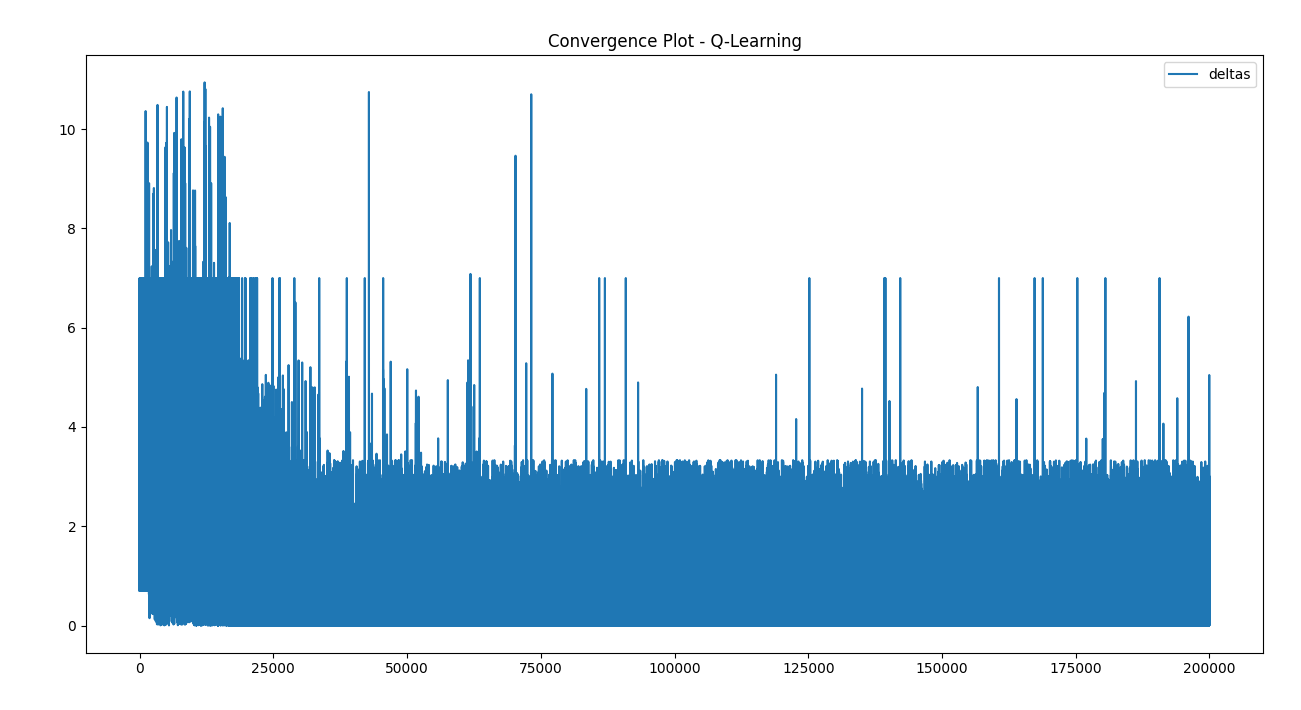

In [ ]:
print(total_reward_convergence[0:100],total_reward_convergence[-100:])
plt.plot( total_reward_convergence[0::100], label="rewards")
plt.legend()
plt.title("Convergence Plot - Q-Learning")
plt.tight_layout()
plt.show()

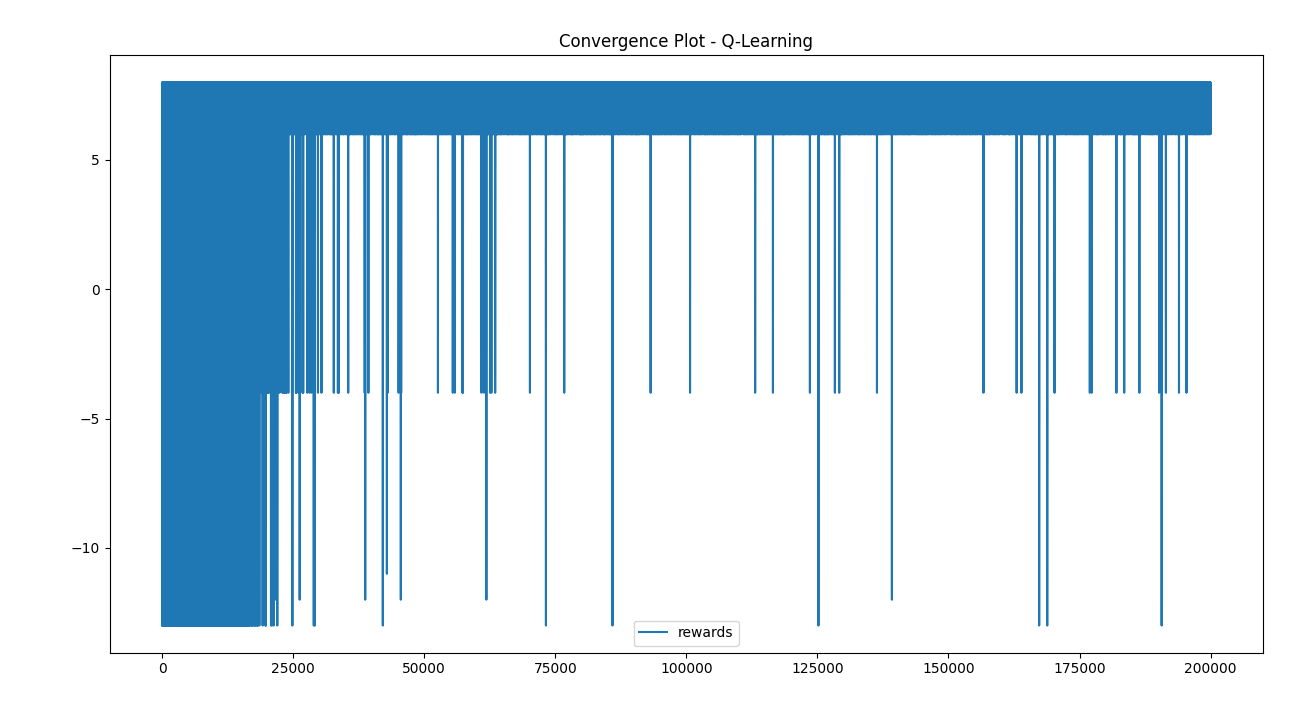

#### Check the Q-dictionary

In [ ]:
# Q_dict

In [ ]:
len(Q_dict)

1418218

In [ ]:
# try checking for one of the states - that which action the agent thinks is the best  
# States_track['x-x-x-x-x-x-x-x-x']
States_track['8-x-x-x-9-x-5-x-4']

{(2, 1): [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

#### Check the states tracked for Q-values convergence


<function matplotlib.pyplot.show>

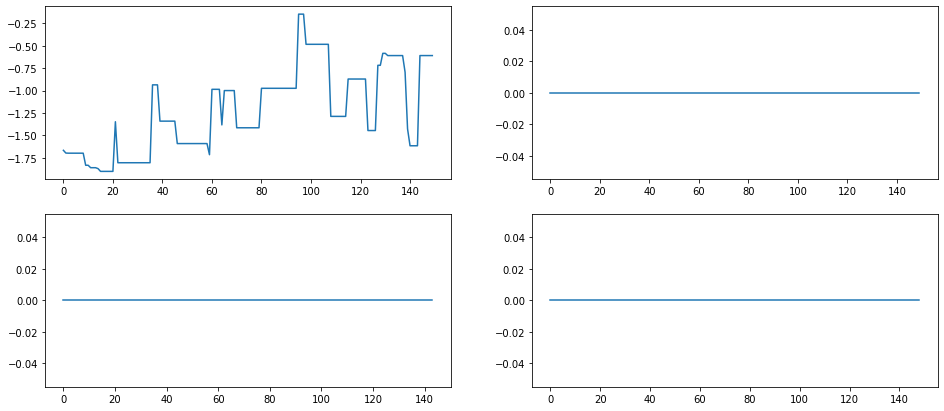

In [ ]:


plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(4,9)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(4,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['8-x-x-x-9-x-5-x-4'][(2,1)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['8-x-x-x-9-x-5-x-4'][(2,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-5-x-4-x-8'][(7,7)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-5-x-4-x-8'][(7,7)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['3-x-x-x-6-x-7-x-8'][(3,5)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['3-x-x-x-6-x-7-x-8'][(3,5)]))
plt.show



On playing the game against the agent (script play_against_tictactoe_agent.py), it was found that the **agent being first to play the move, always starts with 1 at 2nd position**, this automaically reduces a lot of states to be optimised/learnt at the cost of generalization. Hence, the 4 cases above are almost never learnt on priority since they will never occur.

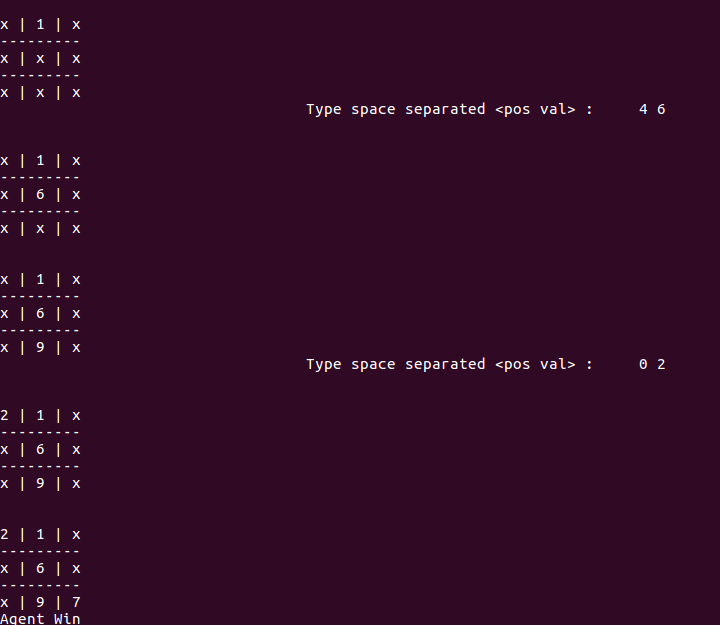

### Epsilon - decay check

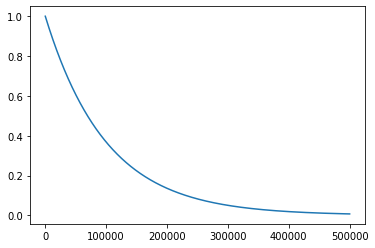

In [ ]:
# max_epsilon = 1.0
# min_epsilon = 0.001
# decay_rate = 0.00001
# EPISODES = 500000
time_x = np.arange(0,EPISODES)
epsilon = []
for time_i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time_i))

plt.plot(time_x, epsilon)
plt.show()

In [ ]:
# once the policy is learnt, we will test it on the actual environment
###### TODO, avg reward should be 7+
reward = 0
for s in range(10000 - 1):
    a = np.argmax(Q[s, :])
    reward += env.values[s][a]
print(reward)